# Lector y graficador de archivos ".json"

## Importo librerias

In [1]:
import json
import os
import tkinter as tk
from tkinter import filedialog
import re
import matplotlib.pyplot as plt
import numpy as np
import struct

## Funcion que abre los archivos y devuelve una lista
Toma las direccion de la carpeta y de la lista de archivos ".json", obtiene los datos por sepadaro de los primeros valores enteros y convierte la lista de exadecimales en complemento a uno a valores enteros.

In [2]:
def revisa_json_files(folder_path, file_list):
    # Generamos una lista vacia donde iran los datos de los archivos .json
    result = []
    # Abrimos los archivos en la direccion propuesta y extraemos los datos.
    for file_name in file_list:
        with open(os.path.join(folder_path, file_name), "r") as f:
            data = json.load(f)
        record = {
            "Id": int(data["Id"]),
            "Frec1": int(data["Frec1"]),
            "IncF": int(data["IncF"]),
            "Nciclos": int(data["Nciclos"]),
            "Aten": int(data["Aten"]),
            "SwIn": int(data["SwIn"]),
            "Filter": int(data["Filter"]),
            "Down": int(data["Down"]),
            "Dummy": int(data["Dummy"]),
            "Nsamp": int(data["Nsamp"]),
            "datos": data["datos"]
        }
        # Agregamos los datos en una lista
        result.append(record)
    # Convertimos las primeras 10 datas en enteros

#------- Pasar de hexa en complemento a uno a entero ---------    

   # Como la data "datos" esta en exadecimal vamos a procesarla ahora.
    for file in result:
        hex_str = file["datos"]
        # Elimina los corchetes del inicio y fin del string
        hex_str = hex_str.strip("[]")
        # Divide el string en una lista de valores exadecimales
        hex_list = hex_str.split(",")
        # Convierte cada valor hexadecimal de la lista hex_list en un entero y lo asigna a la variable int_list
        int_list = []
        for x in hex_list:
            # Convierte el valor hexadecimal a un entero sin signo de 32 bits
            val = int(x, 16) & 0xFFFFFFFF
            # Verifica si el bit más significativo es 1 para determinar si el valor está en complemento a uno
            if val & 0x80000000:
                # Si el bit más significativo es 1, convierte el valor a su complemento a dos
                val = -(0x100000000 - val)
            # Agrega el valor a la lista de enteros
            int_list.append(val)
        # Actualiza el valor de la clave 'datos' en el diccionario
        file["datos"] = int_list  
#-------------------------------------------------------------    
    return result

Conversion a exadecimal:
Aquí, hemos añadido un bucle for para iterar a través de cada valor hexadecimal en la lista hex_list. Luego, convertimos cada valor hexadecimal a un entero sin signo de 32 bits utilizando el operador & con la máscara 0xFFFFFFFF. Después, comprobamos si el bit más significativo es 1 utilizando la máscara 0x80000000. Si el bit más significativo es 1, convertimos el valor a su complemento a dos utilizando la fórmula -(0x100000000 - val). Finalmente, agregamos el valor a la lista de enteros int_list y actualizamos el valor de la clave 'datos' en el diccionario file.

## Cargo ventana para buscar carpetas
La ventana se genera pero puede que aparezca detraz de otra ventana por lo que hay que buscarla.

In [3]:
root = tk.Tk()
root.withdraw()

# Establece la ventana como siempre en primer plano
root.attributes('-topmost', True)
root.after_idle(root.attributes, '-topmost', False)

initial_dir = r"C:\Users\Ingra\OneDrive\Documentos\EMIC\Ecometrias"
folder_path = filedialog.askdirectory(initialdir=initial_dir)

print(folder_path)

C:/Users/Ingra/OneDrive/Escritorio/Ecometrias/1/_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)


In [4]:
# Utiliza la expresión regular para buscar el último nombre de directorio
match = re.search(r'[^\\/]+(?=[\\/]?$)', folder_path)

if match:
    last_dir_name = match.group()
    print(last_dir_name)
else:
    print("No se encontró un nombre de directorio válido")

_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)


In [5]:
files = os.listdir(folder_path)

json_files = [f for f in files if f.endswith('.json')]

print(json_files)

['_Eco_02_15_24.json', '_Eco_02_20_53.json', '_Eco_02_34_25.json', '_Eco_02_42_17.json', '_Eco_02_48_12.json', '_Eco_02_52_23.json']


In [6]:
# Llamamos a la funcion "revisa_json_files"
result = revisa_json_files(folder_path, json_files)
Id = result[0].get('Id')
Frec1 = result[0].get('Frec1')
IncF = result[0].get('IncF')
Nciclos = result[0].get('Nciclos')
Aten = result[0].get('Aten')
Filter = result[0].get('Filter')
Down = result[0].get('Down')
Dummy = result[0].get('Dummy')
Nsamp = result[0].get('Nsamp')

print("Id: ", Id)
print("Frec1: ",Frec1)
print("IncF: ",IncF)
print("Nciclos: ",Nciclos)
print("Aten: ",Aten)
print("Filter: ",Filter)
print("Down: ",Down)
print("Dummy: ",Dummy)
print("Nsamp: ",Nsamp)

Id:  1
Frec1:  301
IncF:  40
Nciclos:  5
Aten:  0
Filter:  5
Down:  32
Dummy:  0
Nsamp:  16000


### Abro el archibo binario donde guarde la tabla.
Para poder tener el codigo mas limpio.

In [7]:
with open('tabla_seno.bin', 'rb') as file:
    bytes = file.read()
    tabla_seno = struct.unpack('{}H'.format(len(bytes) // 2), bytes)


### Creamos y graficamos la señal de entrada
Cargo la lista del archibo binario

In [8]:
# Se define la frecuencia inicial de la señal senoidal
f = Frec1
# Se crea una lista vacía que se llenará con los valores de la señal muestreada
dMuestra = []
# Se inicializan las variables de iteración
inter = 0
paso = Down // 32
# Se ejecuta un ciclo para generar la señal senoidal
for i in range(Nciclos):
    j = 0
    # Se recorre la tabla de valores precalculados de la función seno
    while j < len(tabla_seno):
        # Se verifica si se debe tomar una muestra en este punto
        if inter % paso == 0:
            # Se obtiene el valor de la función seno en este punto
            y = tabla_seno[j]
            # Se agrega el valor de la muestra a la lista
            dMuestra.append(y)
        # Se avanza al siguiente punto de la señal
        j += f
        # Se incrementa el índice que se utiliza para verificar si se debe tomar una muestra
        inter += 1
    # Se recorre la tabla de valores precalculados de la función seno en sentido inverso
    while j < 2 * len(tabla_seno):
        # Se verifica si se debe tomar una muestra en este punto
        if inter % paso == 0:
            # Se obtiene el valor de la función seno en este punto y se invierte su signo
            y = -tabla_seno[j - len(tabla_seno)]
            # Se agrega el valor de la muestra a la lista
            dMuestra.append(y)
        # Se avanza al siguiente punto de la señal
        j += f
        # Se incrementa el índice que se utiliza para verificar si se debe tomar una muestra
        inter += 1
    # Se ajusta el índice para reiniciar la generación de la señal en la tabla de valores
    j -= 2 * len(tabla_seno)
    # Se incrementa la frecuencia de la señal para el siguiente ciclo
    f += IncF

In [9]:
Senial_entrada = dMuestra
print(len(Senial_entrada))

442


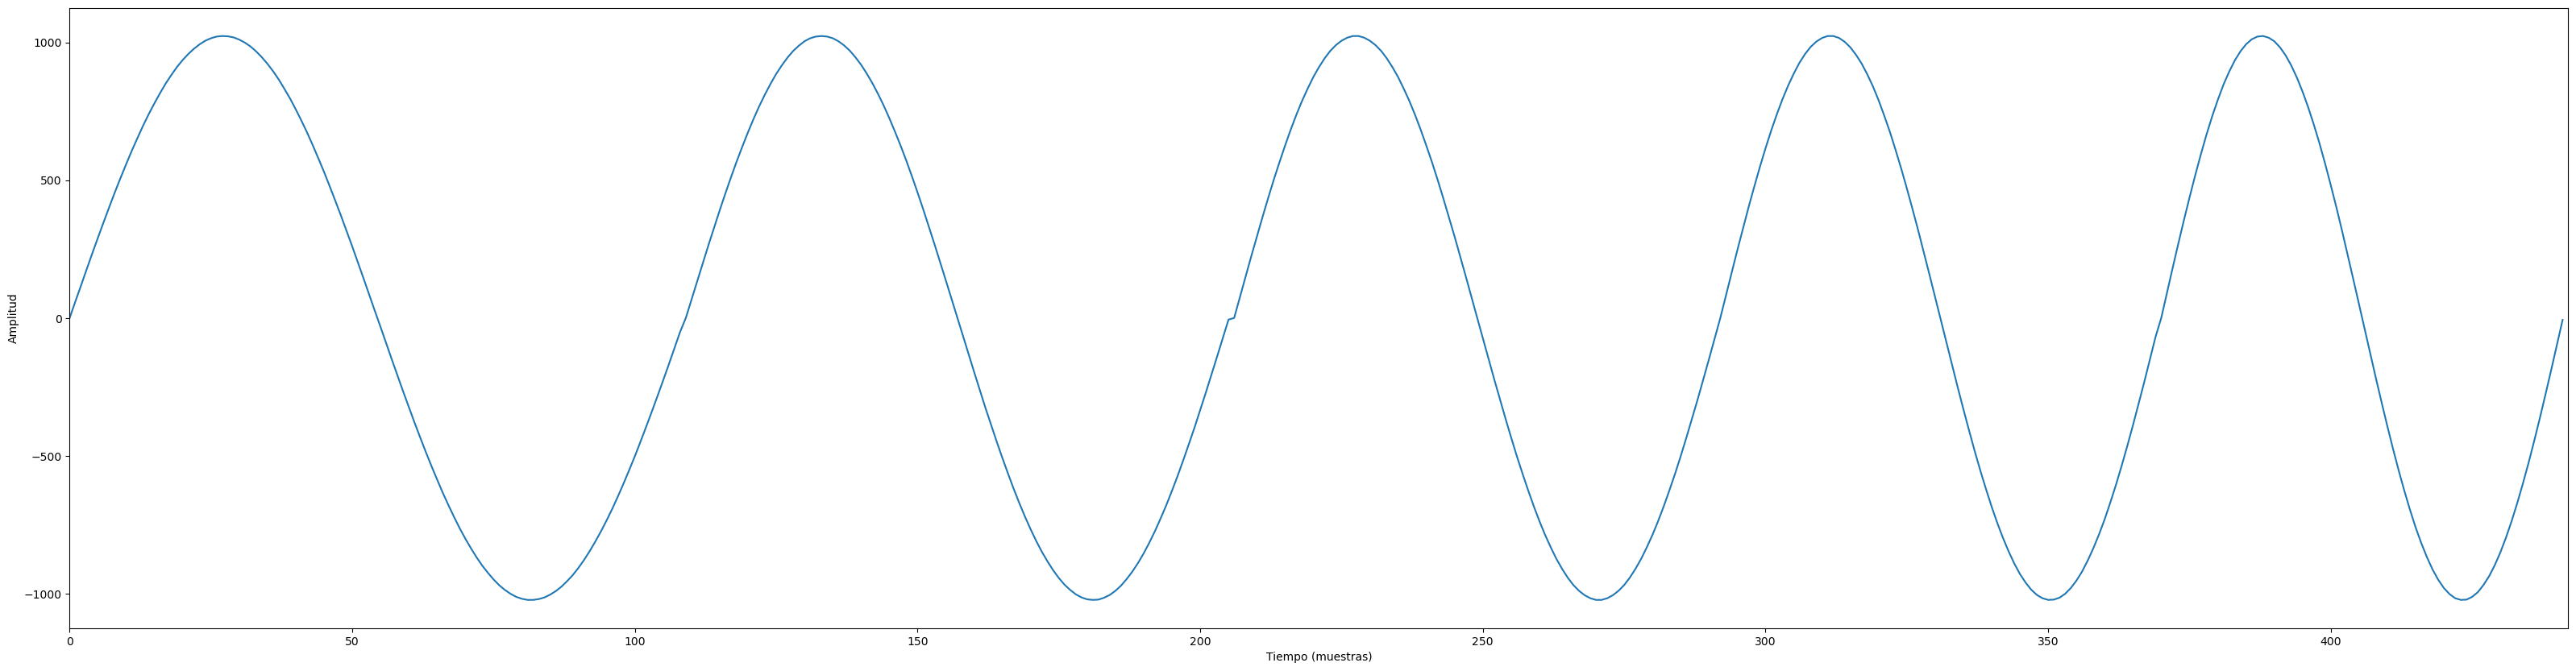

In [10]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(dMuestra) # agregar datos a la gráfica
ax.set_xlim([0, len(Senial_entrada)]) # establecer límites del eje x
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.show()


## Graficamos la señal de salida

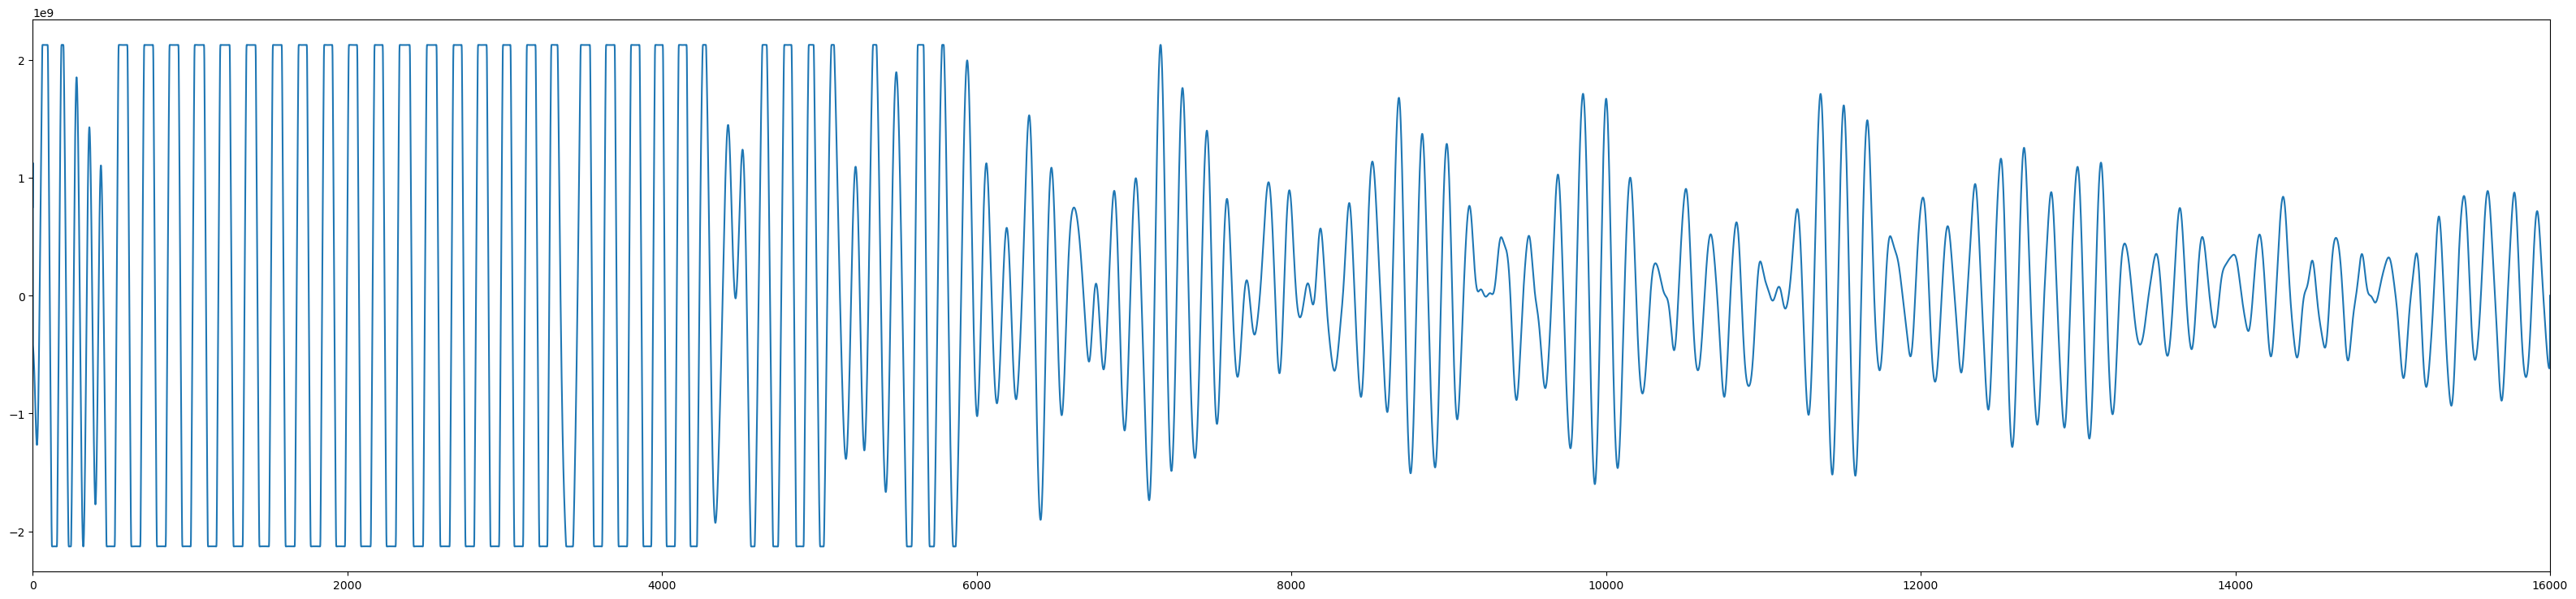

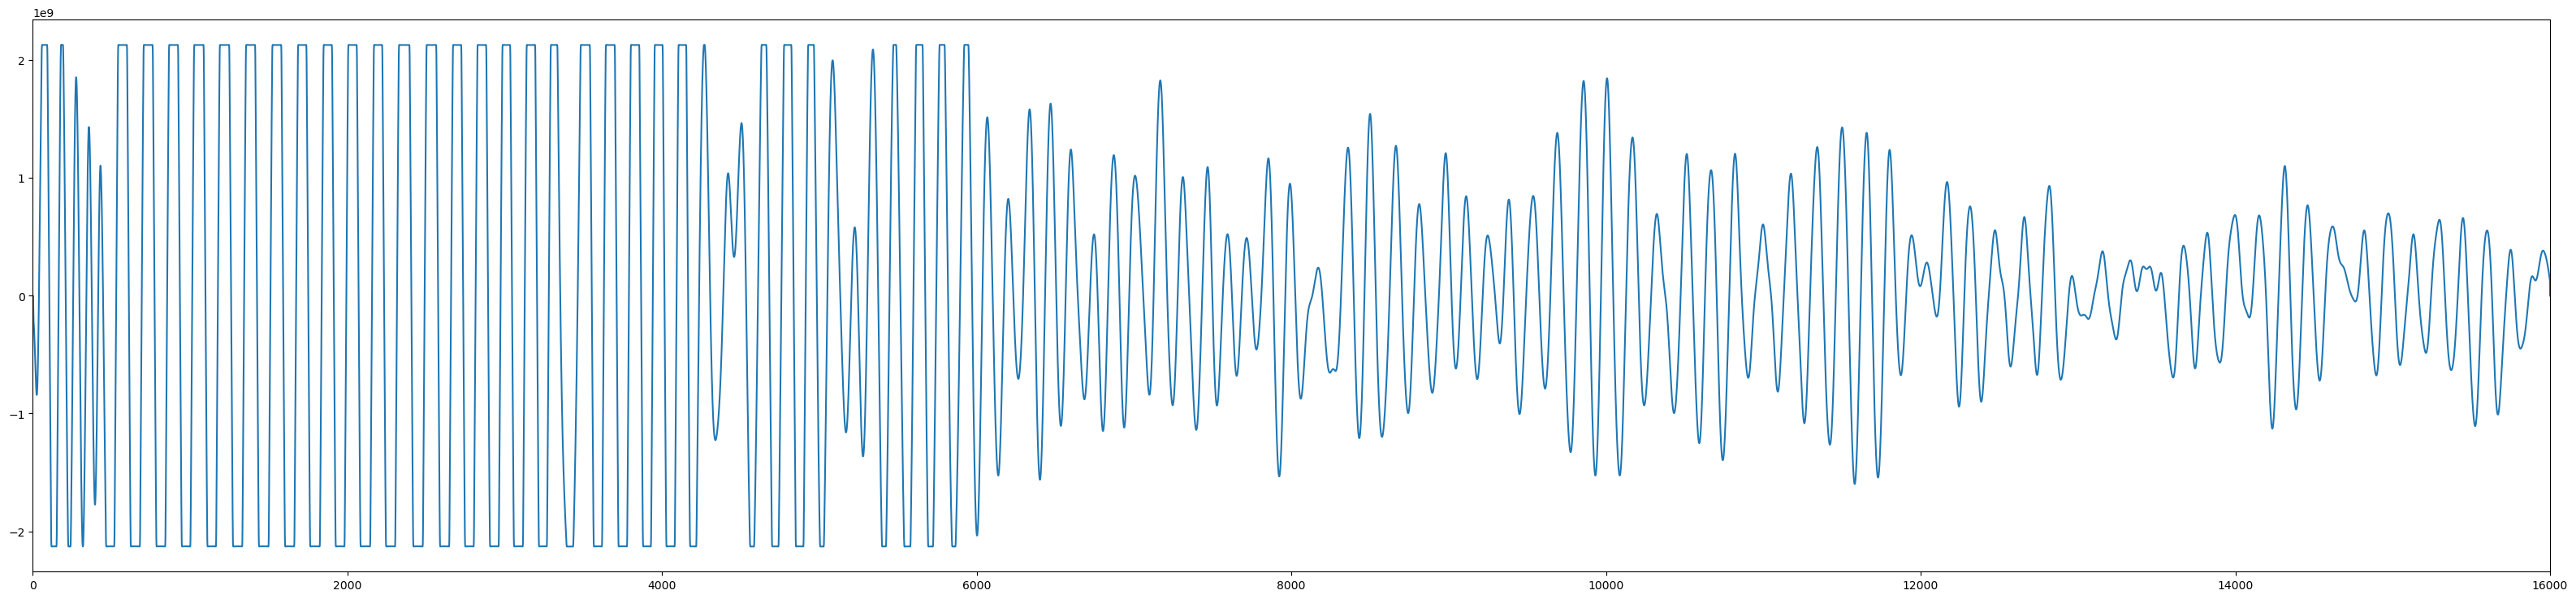

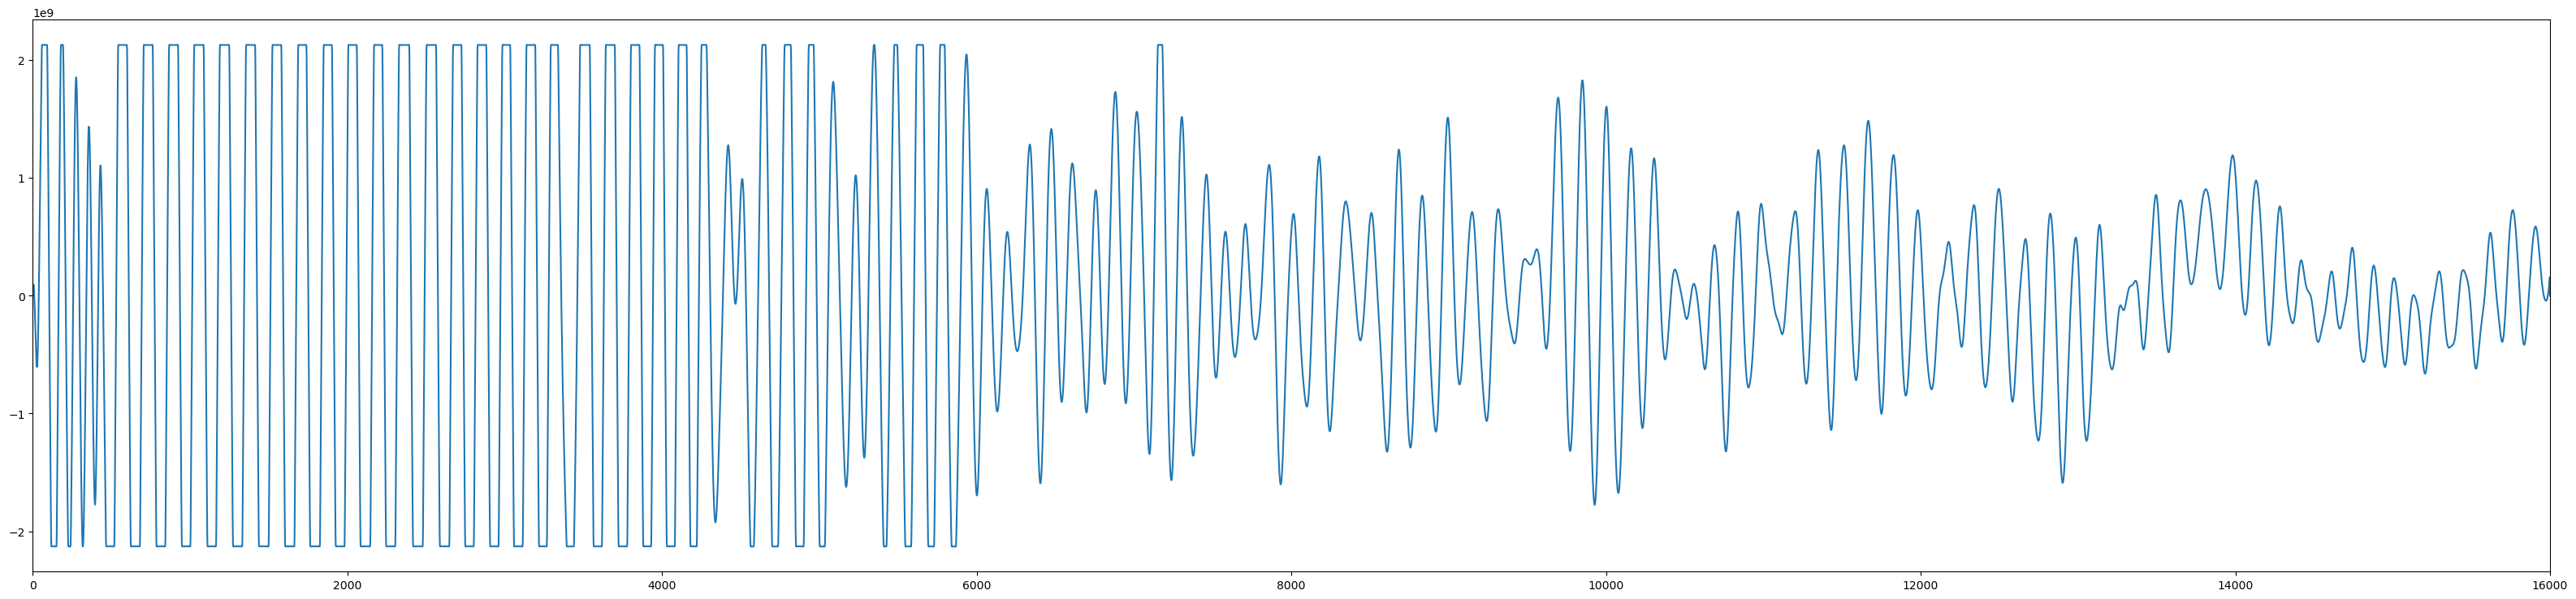

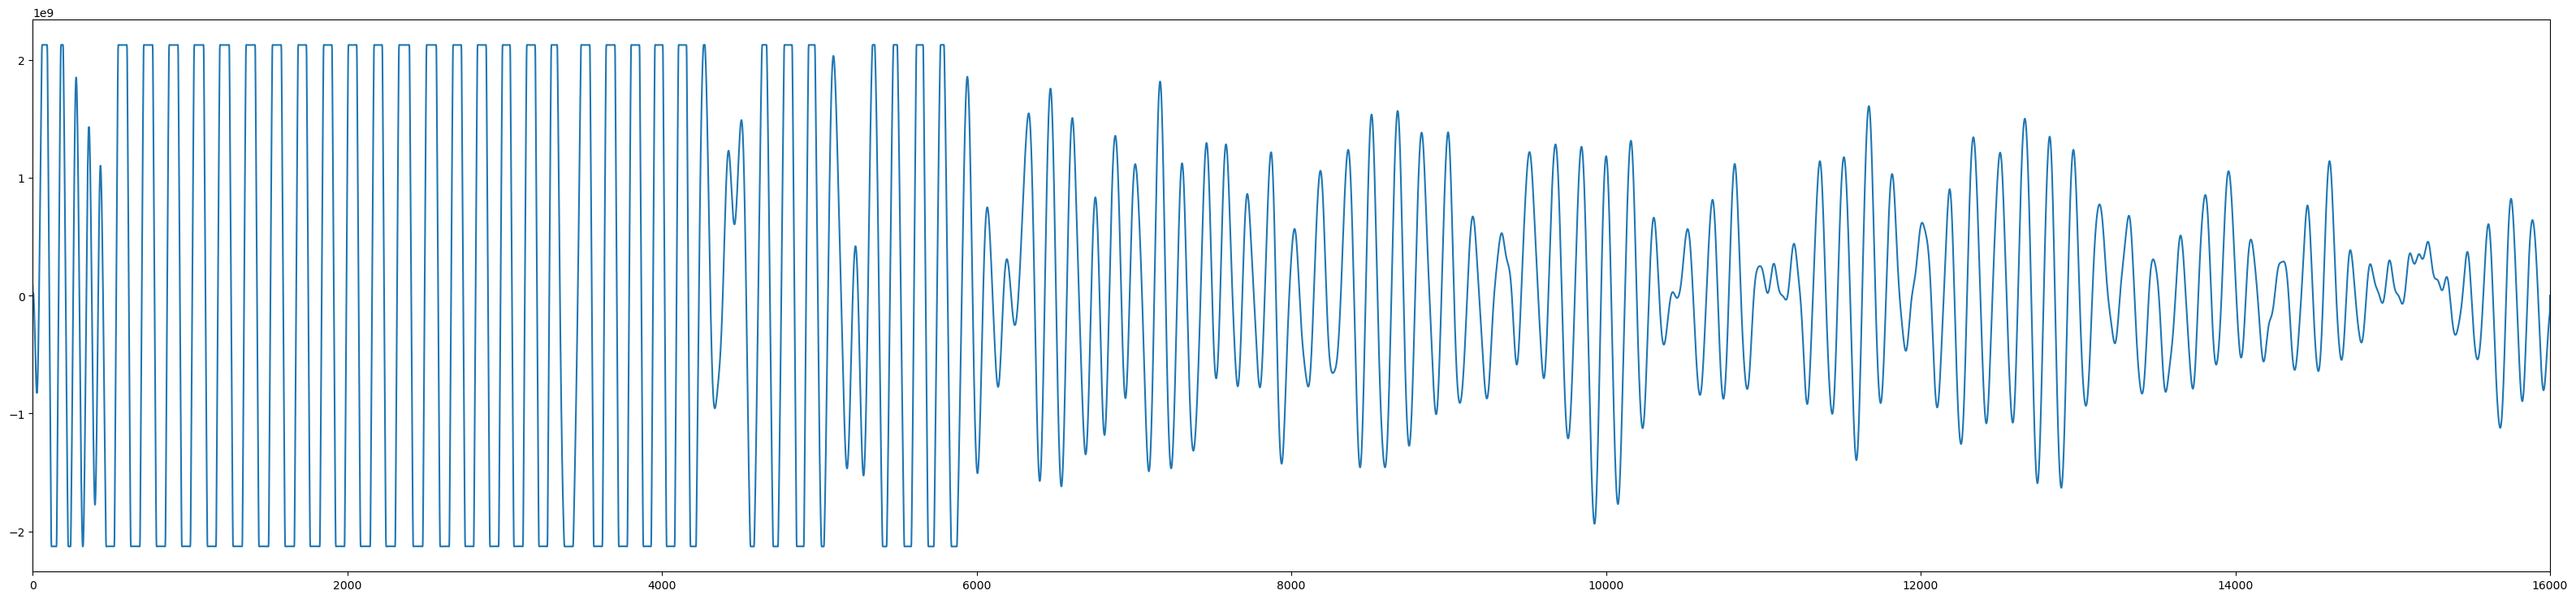

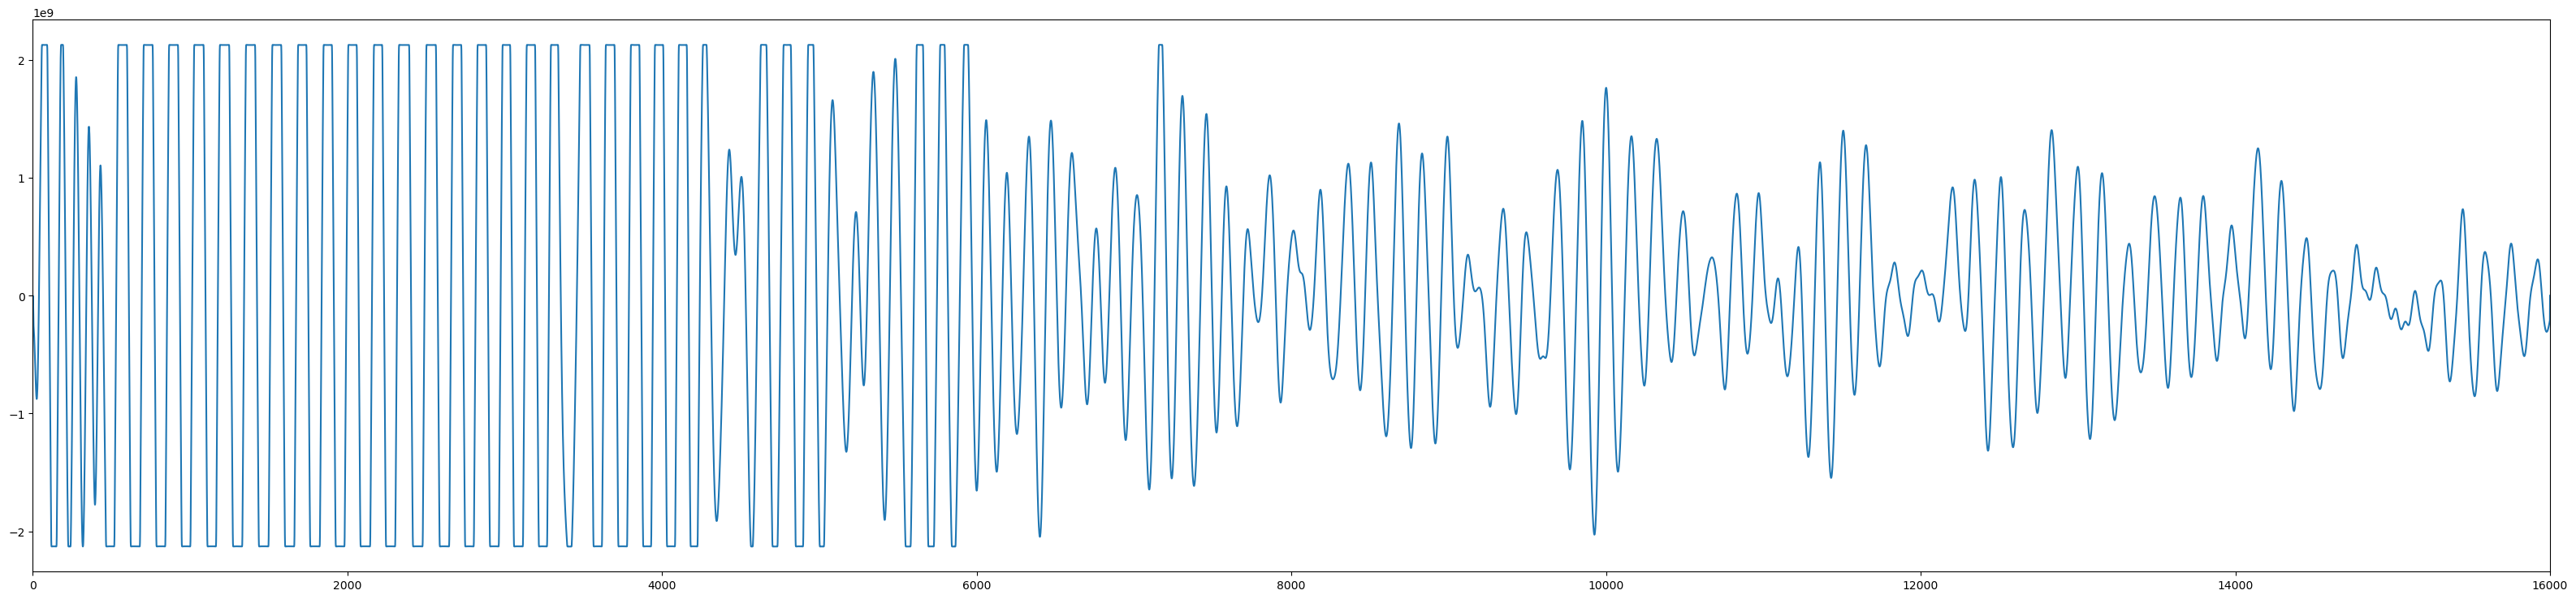

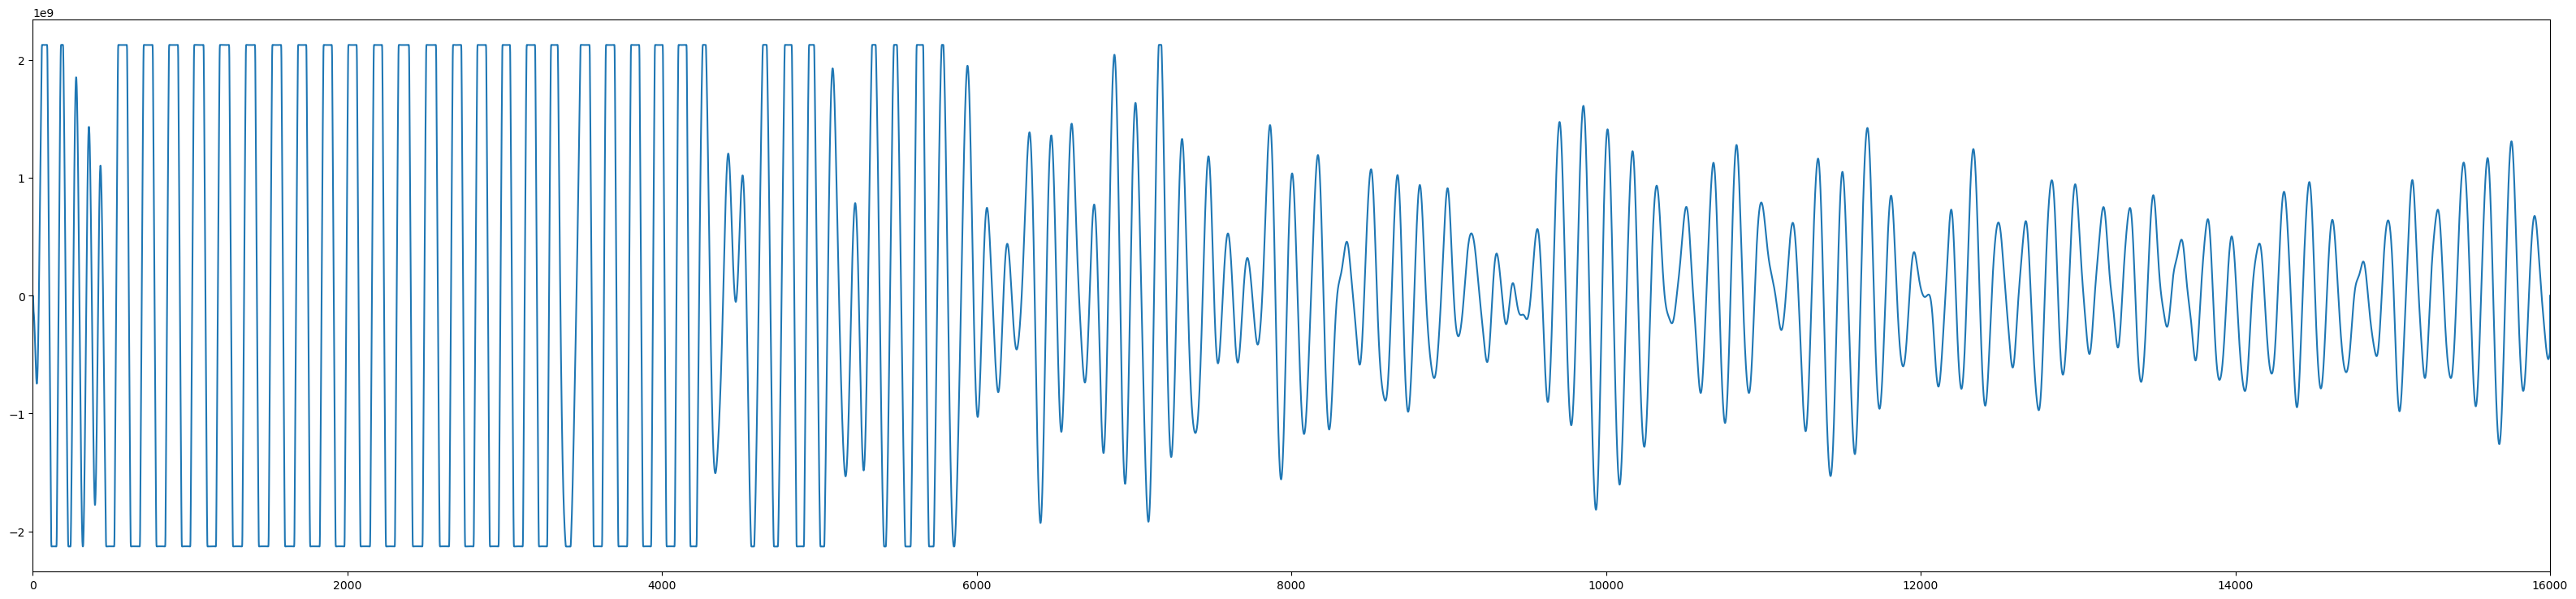

In [11]:
for datos in result:
    # Obtener lista de enteros
    Graficar = datos.get('datos')

    # Generar una lista de n enteros aleatorios
    n = len(Graficar)

    # Crear figura y ejes con barra de desplazamiento
    fig, ax = plt.subplots(figsize=(40, 10))
    fig.subplots_adjust(bottom=0.2)

    # Establecer límites del eje x
    ax.set_xlim([0, n])

    # Tramar la gráfica
    ax.plot(Graficar)

    # Mostrar la gráfica
    plt.show()

## Obtenemos el promedio de las señales.

In [12]:
# Obtener la longitud de las listas en la key 'datos' de un elemento del diccionario
longitud = len(result[0]['datos'])

# Inicializar la lista promedio con ceros, con la misma longitud que las listas en la key 'datos'
promedio = [0] * longitud

# Sumar los valores de las listas en la key 'datos' a la lista 'promedio'
for diccionario in result:
    for i, valor in enumerate(diccionario['datos']):
        promedio[i] += valor

# Dividir cada valor de la lista 'promedio' entre la longitud de la lista de diccionarios
promedio = [x / len(result) for x in promedio]

## Graficamos la señal de entrada y el promedio de la salida

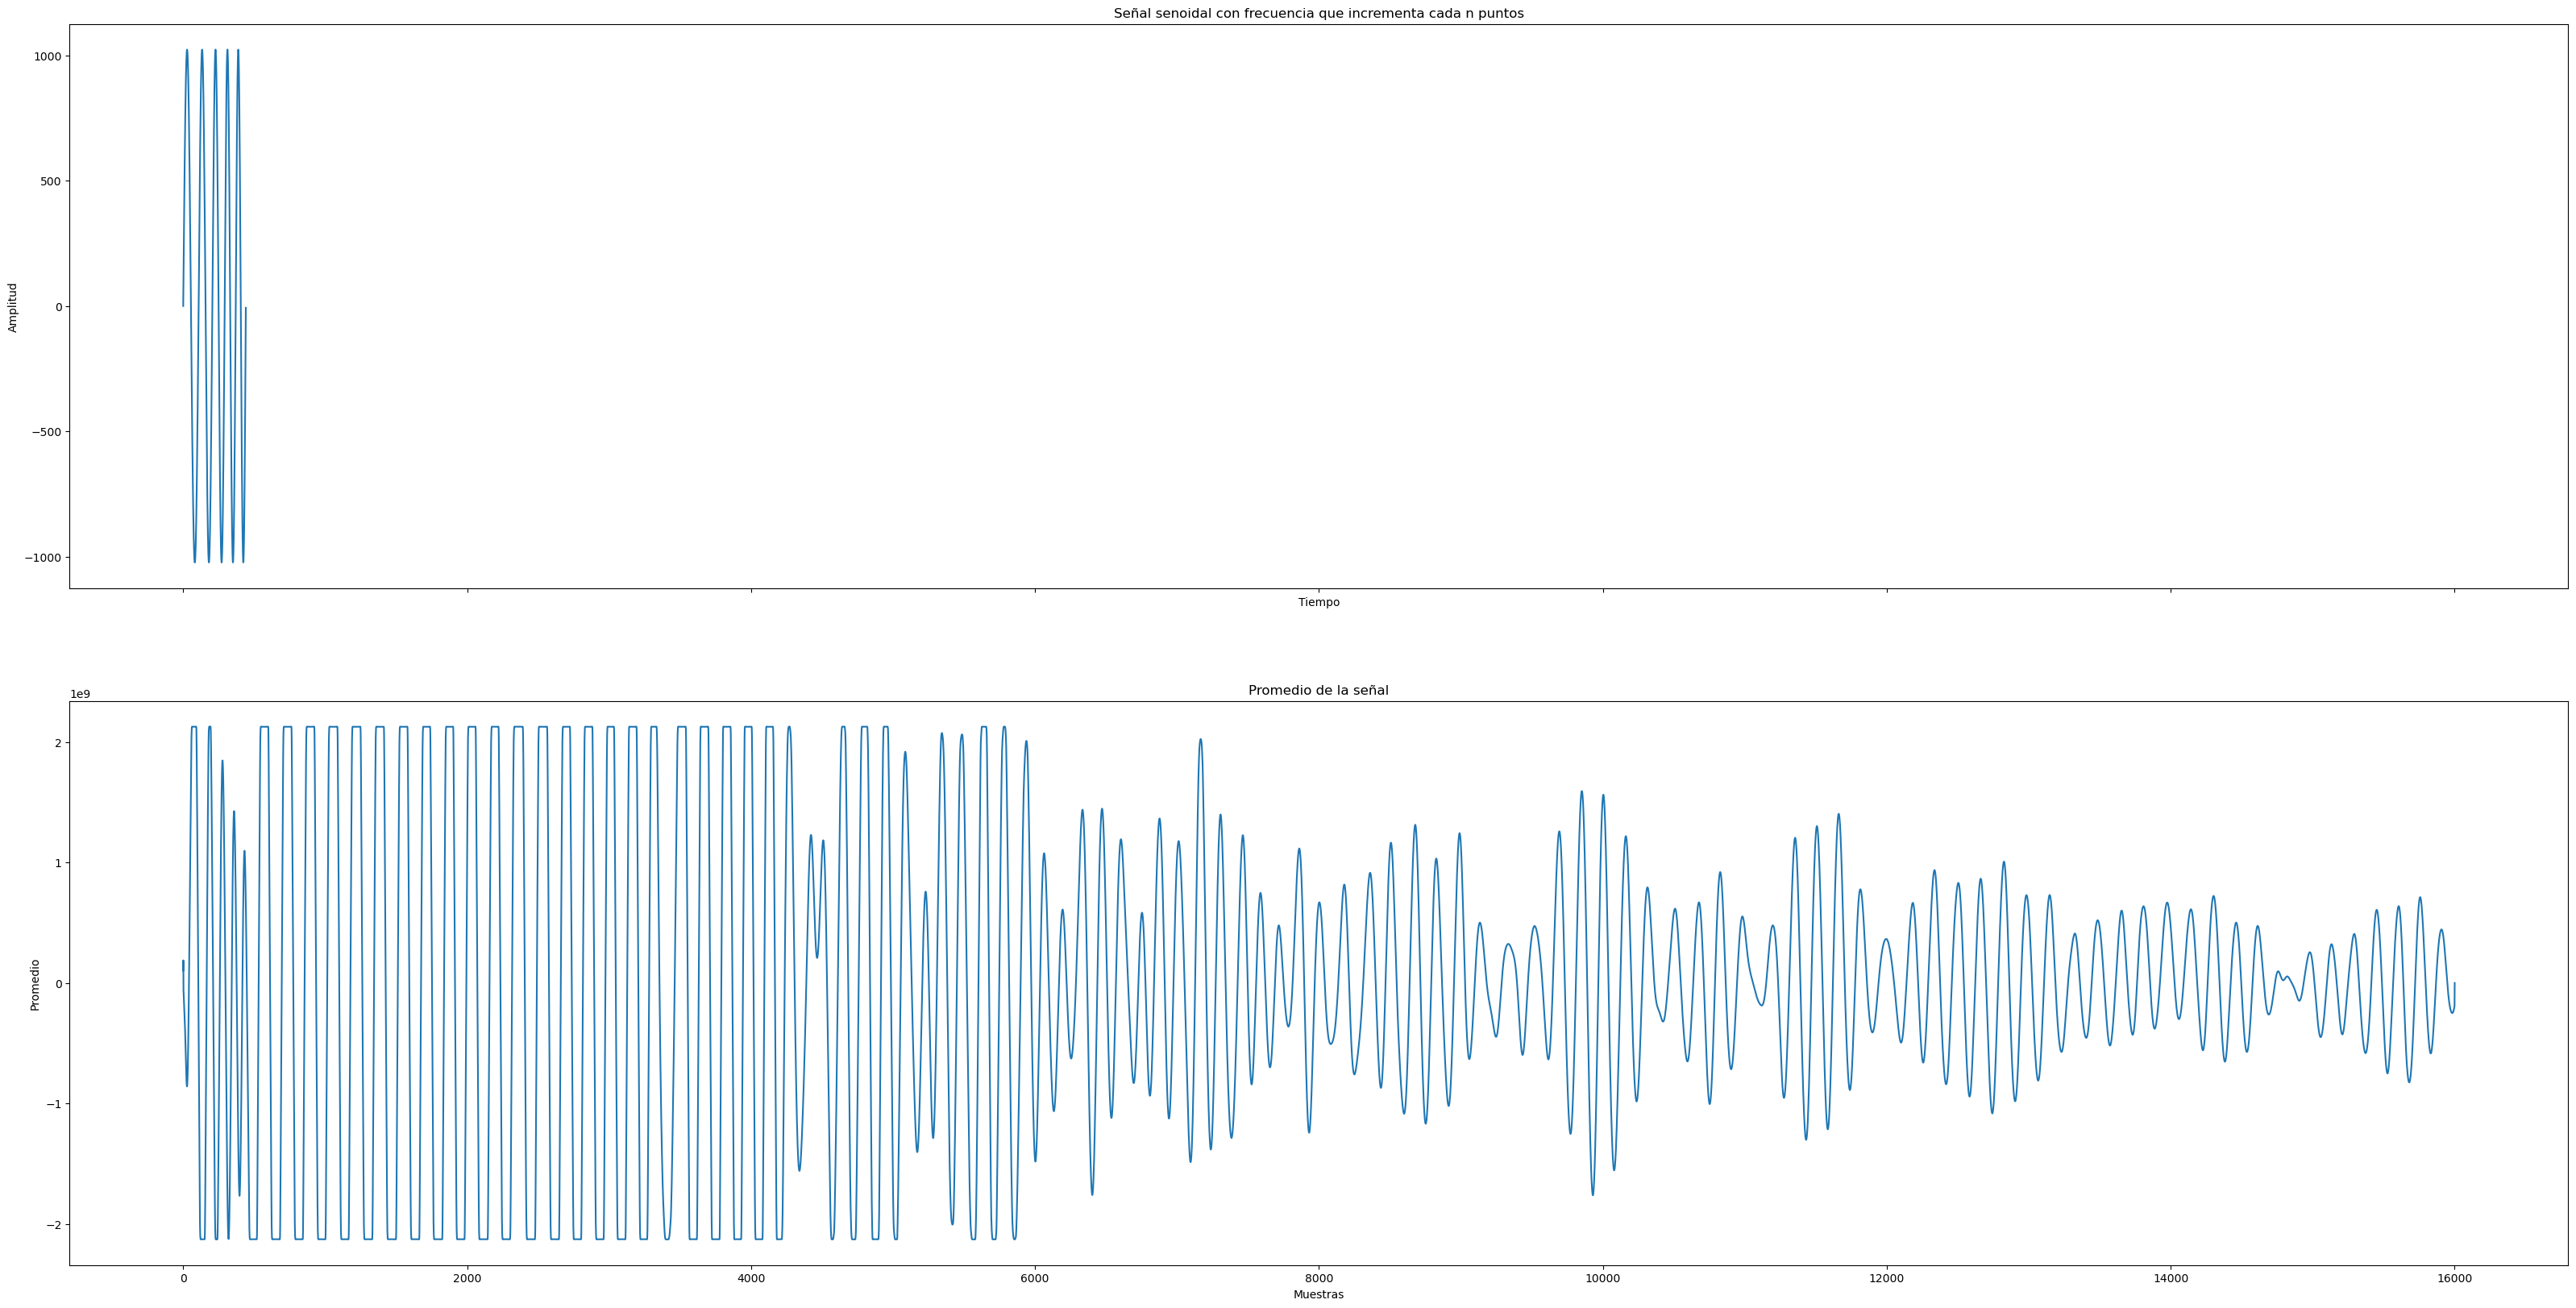

In [13]:
#-----------------------------------------------------------------------

# Configurar la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), sharex=True)

# Graficar señal en el primer subplot
# Graficar señal

ax1.plot(dMuestra) # agregar datos a la gráfica

# Establecer título y etiquetas de los ejes del primer subplot
ax1.set_title('Señal senoidal con frecuencia que incrementa cada n puntos')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Amplitud')

# Graficar la lista de promedios en el segundo subplot
ax2.plot(promedio)

# Establecer título y etiquetas de los ejes del segundo subplot
ax2.set_title('Promedio de la señal')
ax2.set_xlabel('Muestras')
ax2.set_ylabel('Promedio')

# Mostrar la figura
plt.show()
